## Overview

Most clustering methods are designed to work well when the number of points in each cluster is approximately the same.  What about when one cluster has a far larger number of data points?

In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Generating toy data
Here we start with an "equipartioned" sample data set of 600 points (200 per cluster) and then add 6000 more points ten-fold more points to one of the blobs.  (I.e. the total number of points in the largest blob is ~30-fold higher than in the other clusters.

/Users/curt/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


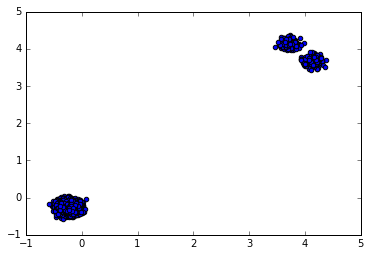

In [2]:
# Generate equipartitioned sample data
centers = [[0, 0], [20, 18], [18, 20]]

X, labels_true = make_blobs(n_samples=600, 
                            centers=centers, 
                            cluster_std=0.4, 
                            random_state=0)

# Generate 10x more data for one cluster
extra_X0, labels_true_extra = make_blobs(n_samples=6000, 
                                    centers=centers[0], 
                                    cluster_std=0.4, 
                                    random_state=0)

# Combine the datasets
X = np.vstack([X, extra_X0])
labels_true = np.concatenate([labels_true, labels_true_extra])


# Scale all the data
X = StandardScaler().fit_transform(X) 

# Plot the data
xx, yy = zip(*X)
plt.scatter(xx, yy)
plt.show()

## Clustering this data with DBSCAN

In [3]:
db = DBSCAN(eps=0.15, min_samples=50).fit(X)
core_samples = db.core_sample_indices_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print n_clusters_

3


## Plotting the results

/Users/curt/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


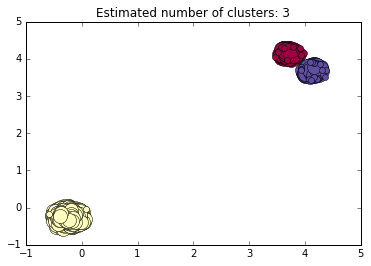

In [4]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

This notebook shows that for well-resolved clusters like these, DBSCAN can handle an 11-fold excess of points in one of the clusters and still return reliable results.

## Timing

I'm not sure if DBSCAN is $O(n\log n)$ or if it is $O(n^2)$ in the number of data points, but it is at least one of those.  For a data set of 6600 data points, the code below shows that the core clustering step takes less than a second.

In [5]:
%timeit db = DBSCAN(eps=0.15, min_samples=50).fit(X)

1 loop, best of 3: 530 ms per loop


## Sources for this code:

* A [question](http://stackoverflow.com/questions/18237479/dbscan-in-scikit-learn-of-python-save-the-cluster-points-in-an-array) on StackOverflow.
* A [scikit-learn help page](http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html) on DBSCAN.